<a href="https://colab.research.google.com/github/kalyankalluri999/Academic-Projects/blob/main/Xception_base_model_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import gc
import random
from itertools import chain
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D, LeakyReLU, Activation
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.applications.inception_v3 import preprocess_input
#from tensorflow.keras.utils.plot_model import plot_model
import tensorflow as tf
from keras.applications.xception import Xception
from keras import optimizers
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
train_data_dir = '/content/gdrive/MyDrive/Newfolder/TEST_data/'
test_data_dir =  '/content/gdrive/MyDrive/Newfolder/TRAIN_data/'
img_width, img_height = 299, 299
channels = 3
batch_size = 64
num_images= 50
image_arr_size= img_width * img_height * channels
#train, val = train_val_split(train_data_dir, train_size=0.8,random_state=0)
#print(train)
#print(test)

In [4]:
train_datagen = ImageDataGenerator(
    rescale= 1./255,
    brightness_range=(0.5,1),
    shear_range= 0.2,
    zoom_range= 0.2,
    horizontal_flip= True,
    rotation_range= 20,
    width_shift_range= 0.2,
    height_shift_range= 0.2,   
    validation_split=0.3,
    

)

valid_datagen = ImageDataGenerator(
    rescale= 1./255, 
    validation_split=0.3
    
)

In [5]:
train_generator = train_datagen.flow_from_directory(  
    train_data_dir,  
    target_size= (img_width, img_height), 
    color_mode= 'rgb',
    batch_size= batch_size,  
    class_mode= 'categorical',
    subset='training',
    shuffle= True, 
    seed= 42
) 

valid_generator = valid_datagen.flow_from_directory(
    train_data_dir,
    target_size= (img_width, img_height),
    color_mode= 'rgb',
    batch_size= batch_size,  
    class_mode= 'categorical',
    subset='validation',
    shuffle= True, 
    seed= 1234
)
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    directory=test_data_dir,
    target_size=(299, 299),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=False,
    seed=42
)

Found 4200 images belonging to 120 classes.
Found 1800 images belonging to 120 classes.
Found 16126 images belonging to 120 classes.


In [6]:
num_classes = len(train_generator.class_indices)  
train_labels = train_generator.classes 
train_labels = to_categorical(train_labels, num_classes=num_classes)
valid_labels = valid_generator.classes 
valid_labels = to_categorical(valid_labels, num_classes=num_classes)
nb_train_samples = len(train_generator.filenames)  
nb_valid_samples = len(valid_generator.filenames)

In [7]:
img_generator_flow_train = train_datagen.flow_from_directory(
    directory=train_data_dir,
    target_size=(299, 299),
    batch_size=16,
    shuffle=True,
    subset="training")

img_generator_flow_valid = train_datagen.flow_from_directory(
    directory=train_data_dir,
    target_size=(299, 299),
    batch_size=16,
    shuffle=True,
    subset="validation")

Found 4200 images belonging to 120 classes.
Found 1800 images belonging to 120 classes.


In [ ]:
#img = load_img('/content/gdrive/MyDrive/data.zip (Unzipped Files)/Train_data/Appenzeller/n02107908_1030-0.jpg')
#data = img_to_array(img)
#samples = tf.expand_dims(data, 0)
#it = train_datagen.flow(samples, batch_size=1)
#
#for i in range(9):
 #   plt.subplot(330 + 1 + i)
  #  batch = it.next()
   # image = batch[0]
   # plt.imshow(image)

#plt.savefig('augmented_image.png', transparent= False, bbox_inches= 'tight', dpi= 900)
#plt.show()
#

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=2, verbose=1, factor=0.5, min_lr=0.00001)
base_model =  Xception(weights='imagenet', include_top=False)
for layer in base_model.layers:
    layer.trainable=False 
base_model.summary()


In [10]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- 
predictions = Dense(120, activation='softmax')(x)
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional Xception layers
for layer in base_model.layers:
    layer.trainable = False   
# this is the model we will train
xception = Model(inputs=base_model.input, outputs=predictions)
xception.compile(loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
checkpoint = ModelCheckpoint(
    'baseline_model.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='auto',
    save_weights_only=False,
    save_freq='epoch'
)
earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=3,
    verbose=1,
    mode='auto'
)
csvlogger = CSVLogger(
    filename= "training_csv.log",
    separator = ",",
    append = False
)
reduceLR = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=1, 
    mode='auto'
)
callbacks = [checkpoint, earlystop, csvlogger,reduceLR]
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.97):
            print("\nReached 97.0% accuracy so cancelling training!")
            
            self.model.stop_training = True

In [12]:
train_datagen = ImageDataGenerator(
    rescale= 1./255,
    brightness_range=(0.5,1),
    shear_range= 0.2,
    zoom_range= 0.2,
    horizontal_flip= True,
    rotation_range= 20,
    width_shift_range= 0.2,
    height_shift_range= 0.2,   
    validation_split=0.3,
)
valid_datagen = ImageDataGenerator(
    rescale= 1./255, 
    validation_split=0.3    
)

In [14]:
training_set = train_datagen.flow_from_directory('/content/gdrive/MyDrive/Newfolder/TEST_data/',
                                                 target_size = (224, 224),
                                                 batch_size = 64,
                                                 class_mode = 'categorical')

Found 6000 images belonging to 120 classes.


In [15]:
test_set = test_datagen.flow_from_directory('/content/gdrive/MyDrive/Newfolder/TRAIN_data/',
                                            target_size = (224, 224),
                                            batch_size = 64,
                                            class_mode = 'categorical')

Found 16126 images belonging to 120 classes.


In [16]:
# fit the model
# Run the cell. It will take some time to execute
r = xception.fit_generator(
  training_set,
  validation_data=training_set,
  epochs=10,
  steps_per_epoch=len(training_set),
  validation_steps=len(training_set)
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/10
94/94 [==============================] - 1189s 12s/step - loss: 1.4115 - accuracy: 0.6425 - val_loss: 0.6710 - val_accuracy: 0.8000
Epoch 2/10
94/94 [==============================] - 245s 3s/step - loss: 0.7655 - accuracy: 0.7705 - val_loss: 0.6314 - val_accuracy: 0.8013
Epoch 3/10
94/94 [==============================] - 254s 3s/step - loss: 0.6727 - accuracy: 0.7975 - val_loss: 0.5387 - val_accuracy: 0.8285
Epoch 4/10
94/94 [==============================] - 250s 3s/step - loss: 0.5724 - accuracy: 0.8225 - val_loss: 0.4710 - val_accuracy: 0.8497
Epoch 5/10
94/94 [==============================] - 252s 3s/step - loss: 0.5243 - accuracy: 0.8308 - val_loss: 0.4004 - val_accuracy: 0.8688
Epoch 6/10
94/94 [==============================] - 251s 3s/step - loss: 0.4901 - accuracy: 0.8390 - val_loss: 0.4170 - val_accuracy: 0.8668
Epoch 7/10
94/94 [==============================] - 250s 3s/step - loss: 0.4540 - accuracy: 0.8495 - val_loss: 0.3776 - val_accuracy: 0.8778
Epoch 8/10


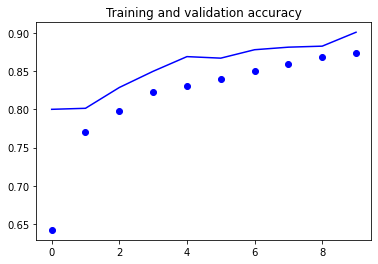

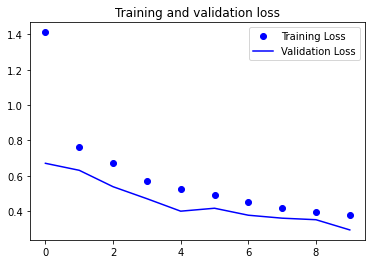

In [17]:
acc = r.history['accuracy']
val_acc = r.history['val_accuracy']
loss = r.history['loss']
val_loss = r.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

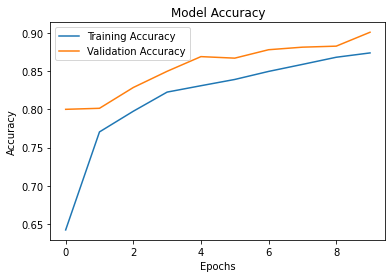

In [19]:
plt.subplot()
plt.title('Model Accuracy')
plt.plot (r.history['accuracy'])
plt.plot (r.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training Accuracy','Validation Accuracy'])
plt.savefig('baseline_acc_epoch.png', transparent= False, bbox_inches= 'tight', dpi= 900)
plt.show()

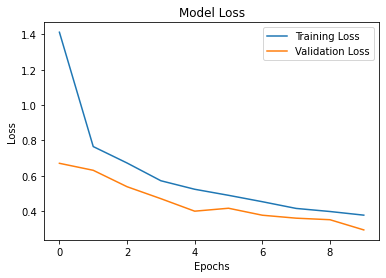

In [21]:
plt.title('Model Loss')
plt.plot(r.history['loss'])
plt.plot(r.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training Loss','Validation Loss'])
plt.savefig('baseline_loss_epoch.png', transparent= False, bbox_inches= 'tight', dpi= 900)
plt.show()